In [1]:
import pandas as pd
import numpy as np

from PIL import Image, ImageStat
import seaborn as sns
import matplotlib.pyplot as plt

from src.plotting_functions import plot_value_counts, numerical_histogram_1d, plot_cont_per_class

from basic_image_eda import BasicImageEDA


In [2]:
df = pd.read_csv("data/butterfly_mimics/images.csv")

In [3]:
df.head()

,image,name,stage,side
0,ggc1e08cbc,monarch,adult,ventral
1,gh150f104b,tiger,adult,both
2,gh20ab0d9c,black,adult,dorsal
3,gh2d5c8c79,monarch,adult,dorsal
4,gh6adf74a4,pipevine,adult,dorsal


Preliminary check to ensure that there is no missing data in the train set. 

In [3]:
df.isnull().sum()

image    0
name     0
stage    0
side     0
dtype: int64

### Data Overview

Train set contains 853 images, with the following features in the csv file:
- image: file name of the corresponding .jpg file
- Name: name of the butterfly species. This is also the **label**. There are 6 classes in this multi-class image classification problem
- stage: the lifecycle stage butterfly is in.  
- side: side of the butterfly where the photo is taken. There are 3 unique categories for this feature.

Few observations from the dataset:
- image types are all in .jpg format, so we won't have to account for more uncommon image file types. 
- All images have been given the "adult" category for the stage feature. Given that there is no variance in the lifecycle stage of the images, the 'stage' feature is likely inconsequential for our problem

In [4]:
df.shape

(853, 4)

### Target distribution
1. Biggest proportion (22.5%) of images belong to the 'pipevine' class, while 'spicebush' (12.7%) and 'viceroy' (12.8%) had the smallest proportions of images.
2. As there is some inbalance in the class distribution, it would be helpful to stratify on classes when we perform the train-val split during model training. This ensures that no class is over/under represented and that the original proportions of examples are kept.


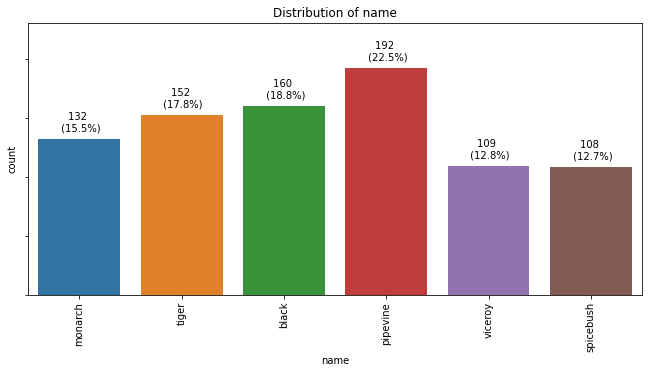

In [5]:
plot_value_counts(df = df, feature_x = "name")

### Side distribution
1. Dorsal had the highest proportion of images (53.9%), and ventral had the smallest proportion (21.9%)
2. As there is quite a bit of variation across the distribution, it could also be worthwhile to consider this feature during the splitting of data into train and validation sets. 

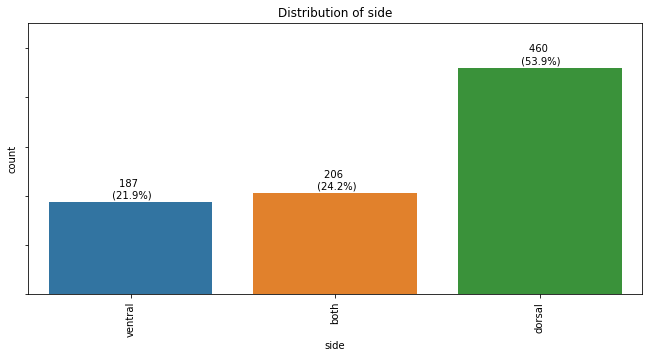

In [6]:
plot_value_counts(df = df, feature_x = "side")

### crosstab between name and side
- As expected, when segmented by classes, the most dominant side is often dorsal, with the exception of the monarch butterflies. For this class of butterflies, most of the images provided tend to be taken from the ventral side. 
- Given that there is variation in the sides of the photos conditional on class, this reinforces the notion that the train-validation split should take both features into account. Besides, the side feature should be an important feature in the model, as the same species of butterfly may look different depending on the side the photo is taken.  

In [7]:
pd.crosstab(df["name"], df["side"], normalize="index")

side,both,dorsal,ventral
name,,,
black,0.275000,0.637500,0.087500
monarch,0.151515,0.393939,0.454545
pipevine,0.343750,0.401042,0.255208
spicebush,0.333333,0.509259,0.157407
tiger,0.151316,0.743421,0.105263
viceroy,0.155963,0.559633,0.284404


### Data loading
- loading of image data into a dictionary, where key is the name of butterfly and value is the list of images (as PIL object)


In [8]:
imgs = {class_:[] for class_ in df["name"].unique()}

IMG_PREFIX = "data/butterfly_mimics/images/"

for idx, row in df.iterrows():
    img_path = IMG_PREFIX + row["image"] + ".jpg"
    class_ = row["name"]
    imgs[class_] += [Image.open(img_path)]


In [9]:
# check that all images have beens successfully read
{class_: len(images) for class_, images in imgs.items()}

{'monarch': 132,
 'tiger': 152,
 'black': 160,
 'pipevine': 192,
 'viceroy': 109,
 'spicebush': 108}

In [10]:
IMG_PREFIX = "data/butterfly_mimics/images/"

df["img_pil"] = df["image"].apply(lambda x: Image.open(IMG_PREFIX + x + ".jpg"))
    

Almost all fo the images are 224x224. The remaining 3 images have 224x235, 256x224 and 238x224 as their image sizes. It is also unlikely that the image dimensions would inform us on the class of the image, as the images with the different image sizes belong to mostly different classes. 

In [11]:
df["img_height"] = df["img_pil"].apply(lambda x: x.size[0])
df["img_width"] = df["img_pil"].apply(lambda x: x.size[1])
df["img_size"] = df["img_height"].astype(str) + "x" + df["img_width"] .astype(str)
df["img_size"].value_counts()

224x224    850
224x235      1
256x224      1
238x224      1
Name: img_size, dtype: int64

In [12]:
pd.crosstab(df["name"], df["img_size"])

img_size,224x224,224x235,238x224,256x224
name,,,,
black,159,1,0,0
monarch,132,0,0,0
pipevine,192,0,0,0
spicebush,108,0,0,0
tiger,150,0,1,1
viceroy,109,0,0,0


### Colour distribution
The box plots illustrate the pixel distribution of each class along each RGB channel. The mean pixel intensity is taken for each image, and the means are then used in the plotting of the charts. 

#### Key observations:
- <font color='red'>**red channel**</font>: Interquartile range of all classes are generally comparable, less the viceroy class, where its tails are shorter relative to the other classes. There are also some images with pixel intensities above the upper quartile for each class. The median pixel intensity is highest for the monarch class (around 125) and lowest for tiger class (around 110)
- <font color='green'>**green channel**</font>: Similar to the red channel, IQR is comparable across all classes except for viceroy, although the difference in the range is less pronounced than before. The median values were highest for the black, pipevine and spicebush classes (around 122) and lowest for the tiger class (113).
- <font color='cornflowerblue'>**blue channel**</font>: The median value is lowest for viceroy class (68) and highest for the pipevine class (83). Relative to other channels, the images tend to not have that prominent a shade of blue as the pixel median pixel values are noticeably lower than the median pixel values for the red and green channels. 

In [13]:
# get avg pixel values for RGC channels in each image 
df["avg_pixels"] = df["img_pil"].apply(lambda x: ImageStat.Stat(x).mean)

for i, colour in enumerate(["r", "g", "b"]):
    df[f"avg_{colour}"] = df["avg_pixels"].apply(lambda x: x[i])


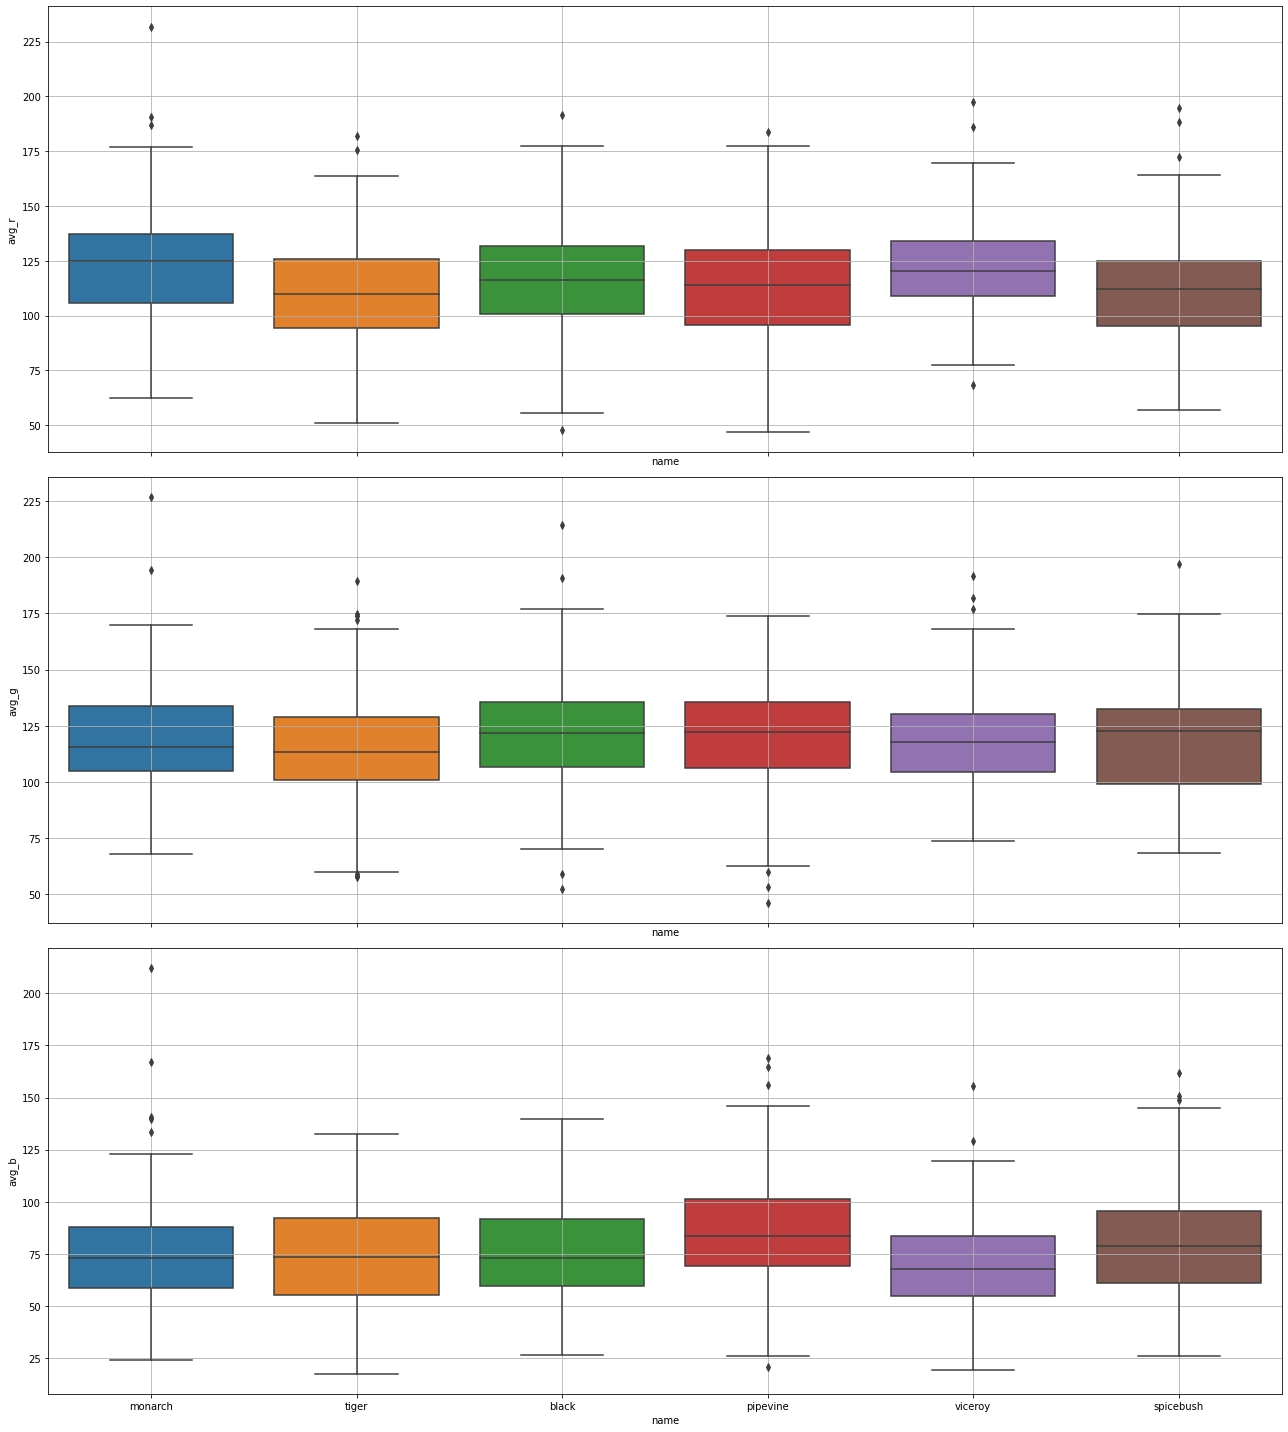

In [15]:
plot_cont_per_class(df = df, cols_to_plot= ["avg_r", "avg_g", "avg_b"], target = "name", fig_size = (18, 20))

### Brightness distribution
source: https://stackoverflow.com/questions/596216/formula-to-determine-perceived-brightness-of-rgb-color 

Brightness of images will be derived through the following formula: 0.2126* R + 0.7152* G + 0.0722* B, where R, G and B are the image's mean pixel values for the red, green and blue channels respectively 

#### Key observations:
- There are no classes with images that are particularly dark. Hypothetically, if such a class exists, it could provide useful information on the environment/ time the butterflies are found in, which could be a feature we incorporate into the model to enhance its accuracy. Alternatively, if there were classes with darker images, it may be helpful to focus on tuning the brightness during augmentation before model training.  
- The tiger class have the lowest median brightness value (110), while the pipevine class has the highest median brightness value (118)

In [16]:
df["brightness"] = df["avg_r"] * 0.2126 + df["avg_g"] * 0.7152 + df["avg_b"] * 0.0722

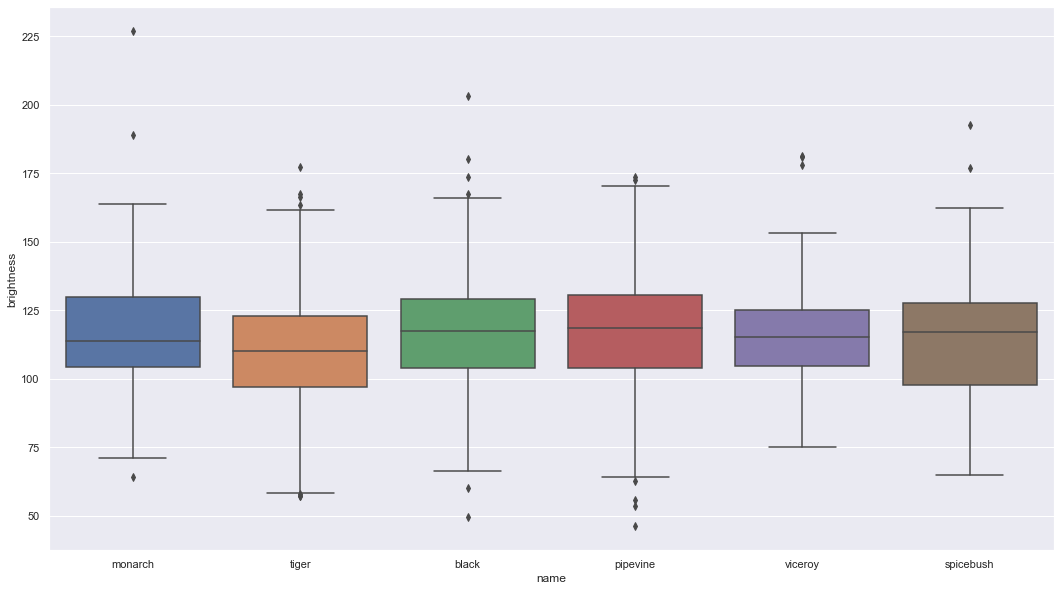

In [18]:
plot_cont_per_class(df = df, cols_to_plot= ["brightness"], target = "name", fig_size = (18, 10))

In [19]:
df.groupby("name")["brightness"].median()

name
black        117.440493
monarch      113.750624
pipevine     118.357255
spicebush    117.163472
tiger        110.250195
viceroy      115.356970
Name: brightness, dtype: float64